In [2]:
using WAV;
using DSP;
using FFTW;
using Plots;
using Statistics;

In [3]:
function countframes(x, framelen::Int, hopsize::Int)
    div(length(x) - framelen, hopsize) + 1
end

function splitframes(x,
                                framelen::Int=1024,
                                hopsize::Int=framelen/2)
    N = countframes(x, framelen, hopsize)
    frames = zeros(typeof(x[1]), framelen, N)

    for i=1:N
        frames[:,i] = x[(i-1)*hopsize+1:(i-1)*hopsize+framelen]
    end

    return frames
end

function stft2(x, 
                       framelen::Int=1024,
                       hopsize::Int=div(framelen,2),
                       window=hanning(framelen))
    frames = splitframes(x, framelen, hopsize)

    freqbins = div(framelen, 2) + 1
    spectrogram = zeros(ComplexF64, freqbins, size(frames,2))
    for i=1:size(frames,2)
        spectrogram[:,i] = rfft(frames[:,i] .* window)
    end

    return spectrogram
end

# istft peforms the Inverse STFT to recover the original signal from STFT 
# coefficients.
function istft(spectrogram,
                           framelen::Int=1024,
                           hopsize::Int=div(framelen,2),
                           window=hanning(framelen))
    numframes = size(spectrogram, 2)

    expectedlen = framelen + (numframes-1)*hopsize
    reconstructed = zeros(expectedlen)
    windowsum = zeros(expectedlen)
    windowsquare = window .* window

    # Overlapping addition
    for i=1:numframes
        s, e = (i-1)*hopsize+1, (i-1)*hopsize+framelen
        r = irfft(spectrogram[:,i], framelen)
        reconstructed[s:e] += r .* window
        windowsum[s:e] += windowsquare
    end

    # Normalized by window
    for i=1:length(reconstructed)
        # avoid zero division
        if windowsum[i] > 1.0e-7
            reconstructed[i] /= windowsum[i]
        end
    end

    return reconstructed
end

istft (generic function with 4 methods)

In [4]:
audio_signal, sample_rate = wavread("../data/tetris_piano_mono.wav")
audio_signal = 0.5*(audio_signal[:,1] + audio_signal[:,2]);

In [5]:
framelen = 2^12;
hopsize = div(framelen,2);
window = hanning(framelen);
audio_stft = stft2(audio_signal,framelen, hopsize,window);

In [6]:
maximum_frequency = 7040.00 * (2^(1/12));
freq = [i*sample_rate/framelen for i = 1:size(audio_stft, 1)];
max_freq_ind = findmin(abs.(freq.-maximum_frequency))[2];

In [7]:
V_mag = abs.(audio_stft[1:max_freq_ind, :]);
V_phase = angle.(audio_stft[1:max_freq_ind, :]);

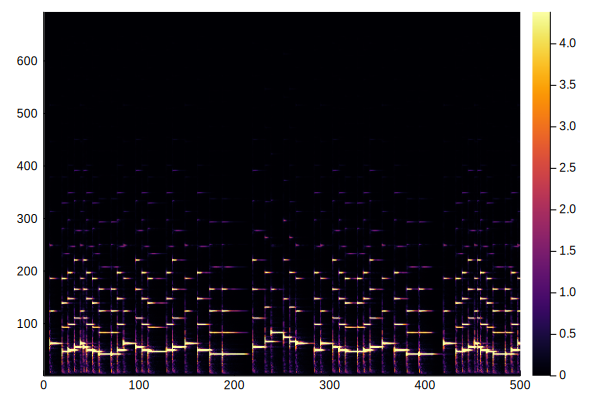

In [8]:
q = quantile(vec(V_mag),0.99);
heatmap(V_mag, clims = (0,q),xlims=(0,500))

In [22]:
V_mag2 = copy(V_mag);
V_mag2[1:100,:] .= 0;
audio_stft2 = copy(audio_stft);
audio_stft2[1:max_freq_ind,:] =  V_mag2 .* exp.(1im*V_phase);

In [23]:
recovered_audio = istft(audio_stft2, framelen, hopsize, window);
wavwrite(recovered_audio, "recovered.wav", Fs=sample_rate);